In [ ]:
import torch
import torch.nn as nn
import re
import numpy as np
import random
import math
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
import nltk # Natural Language Toolkit
nltk.download('stopwords') # Download text data sets, including stop words
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
with open("/content/corpus_pubtator.txt") as file:
  original_corpus = file.readlines()


# Implementing Word2Vec From Scratch


In [ ]:
 # Preprocess the text data and generate a vocabulary
def preprocess_corpus(corpus, min_occurence=5):
    # 1. Extract all the titles and abstracts from the file 
    pattern = "[0-9]+\|[a,t]\|"
    abstracts = [re.sub(pattern, '', i) for i in corpus if re.search(pattern, i)]
    abstracts = " ".join(abstracts)
    # 2. Remove non-letters
    all_words = re.sub("[^a-zA-Z]", " ", abstracts) 

    # 3. Convert to lower case, split into individual words
    all_words = all_words.lower().split()

    # # 4. Remove stop words ("stop words" => frequently occurring words that don't carry much meaning. i.e. "a", "is", "the")
    # stops = set(stopwords.words('english'))
    # meaningful_words = [i for i in all_words if i not in stops]
    # print(f'Step 4: Removing stop words:')
    # print(f'\tReduced total number of words from {len(all_words)} to {len(meaningful_words)}')
    # print(f'\tReduced vocabulary size from {len(set(all_words))} to {len(set(meaningful_words))}')

    # #5a. Apply Snowball Stemmer (a stemmer converts words to its root form)
    # ss = SnowballStemmer('english')
    # all_tokens_stemmer = [ss.stem(i) for i in meaningful_words]
    # print(f'Step 5: Applying Snowball Stemmer:')
    # print(f'\tReduced vocabulary size from {len(set(meaningful_words))} to {len(set(all_tokens_stemmer))}')

    # 5b. Lemmatizing 
    lemmatizer = WordNetLemmatizer()
    all_tokens = [lemmatizer.lemmatize(i) for i in all_words]
    print(f'Step 5: Applying Lemmatizer:')
    print(f'\tReduced vocabulary size from {len(set(all_words))} to {len(set(all_tokens))}')

    # 6. Find counts of each token 
    token_counts = Counter(all_tokens)

    # 7. Filter out words that occur fewer than min_occurence to reduce size of vocabulary
    token_counts = {i:k for i,k in token_counts.items() if k > min_occurence}

    # 8. Create vocabulary
    vocab = list(token_counts.keys())
    vocab_size = len(vocab)
    print(f'Final size of vocabulary: {vocab_size}')

    # 9. Create token_id for each token in vocab and create mapping between {token_id -> token} and {token -> token_id}
    id2token = dict(enumerate(vocab))
    token2id = {v:k for k,v in id2token.items()}

    # 10. Remove rare tokens
    tokens = [i for i in all_tokens if i in token2id]

    return tokens, vocab, id2token, token2id

In [ ]:
class SkipGramDataset(Dataset):
    def __init__(self, corpus, token2id, window_size):
        self.corpus = corpus
        self.token2id = token2id
        self.window_size = window_size
        self.target_context = self.generate_target_context_pairs()
        self.skip_grams = self.generate_skip_grams()

    def __getitem__(self, index):
        return self.skip_grams[index]

    def __len__(self):
        return len(self.skip_grams)

    def generate_target_context_pairs(self):
        target_context = []
        for i, word in enumerate(self.corpus):
            target_id = self.token2id[word]
            context_ids = []
            for j in range(i-self.window_size, i+self.window_size+1,1):
                if j>=0 and j<len(self.corpus) and j!=i:
                    context_ids.append(self.token2id[self.corpus[j]])
            target_context.append((target_id, context_ids))     
        return target_context
    
    def generate_skip_grams(self):
        skip_grams = []
        progress = tqdm(range(len(self.target_context)))
        for target_id, context_id in self.target_context:
            c = torch.zeros(len(token2id))
            prob = 1/len(context_id)
            for i in context_id:
                c[i] += prob
            skip_grams.append((target_id,c))
            progress.update(1)   
        return skip_grams     

In [ ]:
class Word2VecNN(nn.Module):
    def __init__(self, vocab_size, embedding_size):
         super(Word2VecNN, self).__init__()
         self.embedding = nn.Embedding(vocab_size, embedding_size)
         self.linear = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, target):
        hidden = self.embedding(target)
        output = self.linear(hidden)
        return output


In [ ]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
# hyperparameters
EMBEDDING_DIM = 300
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
BATCH_SIZE = 1000
WINDOW_SIZE = 3
MIN_OCCURENCE = 5

Device: cuda


In [ ]:
# Preprocess the corpus and generate a vocabulary
corpus, vocab, id2token, token2id = preprocess_corpus(original_corpus, MIN_OCCURENCE)

Step 5: Applying Lemmatizer:
	Reduced vocabulary size from 36102 to 32871
Final size of vocabulary: 11407


In [ ]:
# Instantiate the Skip-Gram model
w2v_model = Word2VecNN(len(vocab), EMBEDDING_DIM)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(w2v_model.parameters(), lr=LEARNING_RATE)

# Move model to GPU
w2v_model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [ ]:
# Define a DataLoader to iterate over the Skip-Gram input-output pairs
dataset = SkipGramDataset(corpus, token2id, WINDOW_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 951396/951396 [01:32<00:00, 10289.55it/s]


In [ ]:
#training 

progress = tqdm(range(NUM_EPOCHS * len(dataset) // BATCH_SIZE))
loss_progress = []
for epoch in range(NUM_EPOCHS):
    for target, context in dataloader:
        # move to GPU
        target = target.to(device)
        context = context.to(device)
        # zero gradients
        optimizer.zero_grad()
        # forward pass
        output = w2v_model(target)
        # compute loss
        loss = criterion(output, context)
        # backward pass
        loss.backward()
        optimizer.step()
        #progress
        loss_progress.append(loss.item())
        progress.update(1)
    print(f'\nEpoch {epoch+1}/10 -> loss: {loss.item()}')



  3%|▎         | 955/28541 [00:40<22:40, 20.28it/s]


Epoch 1/10 -> loss: 6.877274990081787


  7%|▋         | 1906/28541 [01:18<22:16, 19.93it/s]


Epoch 2/10 -> loss: 6.8330979347229


 10%|█         | 2857/28541 [01:55<21:38, 19.78it/s]


Epoch 3/10 -> loss: 6.684240341186523


 13%|█▎        | 3811/28541 [02:33<19:38, 20.99it/s]


Epoch 4/10 -> loss: 6.649930477142334


 17%|█▋        | 4762/28541 [03:10<20:27, 19.37it/s]


Epoch 5/10 -> loss: 6.5963454246521


 20%|██        | 5713/28541 [03:47<18:57, 20.06it/s]


Epoch 6/10 -> loss: 6.601461410522461


 23%|██▎       | 6667/28541 [04:24<17:49, 20.45it/s]


Epoch 7/10 -> loss: 6.526730537414551


 27%|██▋       | 7618/28541 [05:02<17:11, 20.28it/s]


Epoch 8/10 -> loss: 6.53032112121582


 30%|███       | 8569/28541 [05:39<16:57, 19.62it/s]


Epoch 9/10 -> loss: 6.466095447540283


 33%|███▎      | 9523/28541 [06:15<15:13, 20.82it/s]


Epoch 10/10 -> loss: 6.307358264923096


 37%|███▋      | 10474/28541 [06:52<14:41, 20.50it/s]


Epoch 11/10 -> loss: 6.386828422546387


 40%|████      | 11425/28541 [07:29<14:00, 20.37it/s]


Epoch 12/10 -> loss: 6.413100719451904


 43%|████▎     | 12379/28541 [08:05<12:52, 20.92it/s]


Epoch 13/10 -> loss: 6.438106060028076


 47%|████▋     | 13330/28541 [08:42<12:31, 20.25it/s]


Epoch 14/10 -> loss: 6.47542667388916


 50%|█████     | 14281/28541 [09:19<12:00, 19.80it/s]


Epoch 15/10 -> loss: 6.397305488586426


 53%|█████▎    | 15235/28541 [09:56<10:34, 20.98it/s]


Epoch 16/10 -> loss: 6.4317145347595215


 57%|█████▋    | 16186/28541 [10:33<10:24, 19.79it/s]


Epoch 17/10 -> loss: 6.376096248626709


 60%|██████    | 17137/28541 [11:10<09:23, 20.24it/s]


Epoch 18/10 -> loss: 6.378512382507324


 63%|██████▎   | 18091/28541 [11:47<08:19, 20.92it/s]


Epoch 19/10 -> loss: 6.1599860191345215


 67%|██████▋   | 19042/28541 [12:23<07:50, 20.18it/s]


Epoch 20/10 -> loss: 6.294219017028809


 70%|███████   | 19993/28541 [13:00<06:58, 20.42it/s]


Epoch 21/10 -> loss: 6.324338436126709


 73%|███████▎  | 20947/28541 [13:37<06:06, 20.70it/s]


Epoch 22/10 -> loss: 6.358175277709961


 77%|███████▋  | 21898/28541 [14:13<05:25, 20.39it/s]


Epoch 23/10 -> loss: 6.387348651885986


 80%|████████  | 22849/28541 [14:50<04:38, 20.45it/s]


Epoch 24/10 -> loss: 6.356710433959961


 83%|████████▎ | 23803/28541 [15:27<03:49, 20.68it/s]


Epoch 25/10 -> loss: 6.302180290222168


 87%|████████▋ | 24754/28541 [16:03<03:03, 20.66it/s]


Epoch 26/10 -> loss: 6.294306755065918


 90%|█████████ | 25705/28541 [16:40<02:20, 20.18it/s]


Epoch 27/10 -> loss: 6.3168559074401855


 93%|█████████▎| 26659/28541 [17:17<01:29, 20.99it/s]


Epoch 28/10 -> loss: 6.259531497955322


 97%|█████████▋| 27610/28541 [17:53<00:46, 20.05it/s]


Epoch 29/10 -> loss: 6.203258037567139


28558it [18:29, 26.30it/s]


Epoch 30/10 -> loss: 6.130033016204834


In [ ]:
# Extract and save the word embeddings
word_embeddings = w2v_model.embedding.weight.data
torch.save(word_embeddings, 'word_embeddings.pt')

In [ ]:
word_embeddings = torch.load('word_embeddings.pt')
print(word_embeddings.shape)

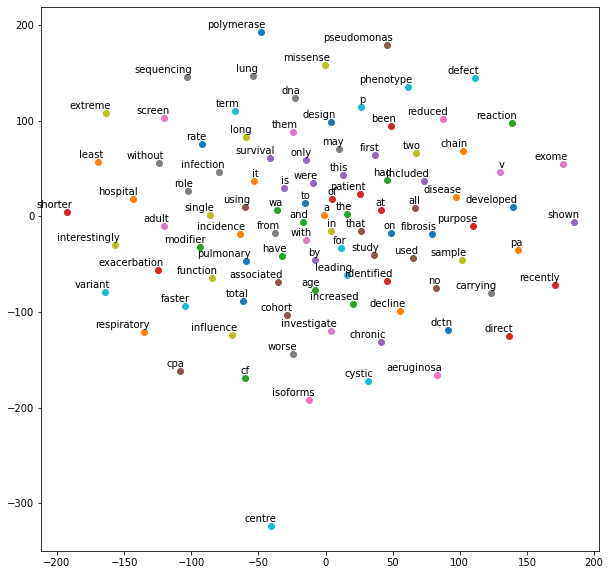

In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
# Compute t-SNE embeddings
tsne_embeddings = TSNE(n_components=2).fit_transform(word_embeddings.cpu().numpy()[0:100,:])
# Plot t-SNE embeddings
plt.figure(figsize=(10, 10))
for i in range(100):
    x, y = tsne_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(id2token[i], xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [ ]:
for i in range(15):

    similarity = torch.nn.functional.cosine_similarity(word_embeddings, word_embeddings[i], dim=1)
    k = 11 # number of closest words to retrieve
    closest_word_indices = similarity.argsort(descending=True)[:k]
    words = []
    for idx in closest_word_indices[1:]:
        words.append(id2token[int(idx.cpu().numpy())])
    print(f'Word: {id2token[i]} -> Closest: {words}')

Word: dctn -> Closest: ['slc', 'others', 'splice', 'kl', 'bmi', 'met', 'bad', 'susceptibility', 'cognitively', 'eukaryote']
Word: a -> Closest: ['ewsr', 'osteomyelitis', 'broad', 'phosphodiesterase', 'mabs', 'hdr', 'decisive', 'oligonucleotide', 'dissub', 'paucity']
Word: modifier -> Closest: ['releasing', 'esthetic', 'hexim', 'lxr', 'generalized', 'mci', 'perfringens', 'ref', 'explicit', 'sorafenib']
Word: of -> Closest: ['atoh', 'describes', 'nodulation', 'fr', 'atlantic', 'ecology', 'mput', 'implantable', 'spondylitis', 'inos']
Word: chronic -> Closest: ['obstructive', 'neurotoxic', 'endemic', 'mesenteric', 'alcoholic', 'reflux', 'objective', 'acute', 'coinfection', 'intellectual']
Word: pseudomonas -> Closest: ['aeruginosa', 'baumannii', 'ncam', 'rifamycin', 'diethoxylate', 'loaded', 'bacteremia', 'bacterium', 'ribotype', 'dissect']
Word: aeruginosa -> Closest: ['pseudomonas', 'belonged', 'slaughter', 'putida', 'possessing', 'exponential', 'baumannii', 'rank', 'tobramycin', 'pao']


# Implementing Word2Vec From Gensim Library

In [ ]:
from gensim.models import Word2Vec, FastText
from nltk.tokenize import sent_tokenize


In [ ]:
 # Preprocess the text data and generate a vocabulary
def preprocess_corpus(corpus):
    # 1. Extract all the titles and abstracts from the file 
    pattern = "[0-9]+\|[a,t]\|"
    abst_and_title = [sent_tokenize(re.sub(pattern, '', i)) for i in corpus if re.search(pattern, i)]

    sentences = []
    for i in abst_and_title: 
        for sent in i:
            pattern = r'\b[^a-zA-Z\s]*\b'
            temp = re.sub(pattern, '', sent) # remove all words that do not contain at least one alphabet
            sentences.append(re.sub("[^a-zA-Z0-9]", " ", temp).lower().split()) # remove all characters that are not digits or alphabets
    return sentences

In [ ]:
sentences = preprocess_corpus(original_corpus)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [ ]:
model = Word2Vec(sentences, min_count=5, window=3, sg=1, compute_loss=True, callbacks=[callback()], iter=8)

Loss after epoch 0: 2759421.0
Loss after epoch 1: 1857271.0
Loss after epoch 2: 1771844.5
Loss after epoch 3: 1574074.0
Loss after epoch 4: 1557478.5
Loss after epoch 5: 1355659.0
Loss after epoch 6: 1342774.0
Loss after epoch 7: 1374697.0


In [ ]:
print(model.wv.most_similar('hospital', topn=10))
print(model.wv['hospital'].shape)

[('icu', 0.7706996202468872), ('outpatient', 0.7694927453994751), ('department', 0.7684365510940552), ('university', 0.7612595558166504), ('hospitals', 0.7521671056747437), ('tertiary', 0.749620795249939), ('texas', 0.7469611167907715), ('emergency', 0.7466414570808411), ('inpatient', 0.7464724183082581), ('unit', 0.7393064498901367)]
(100,)


# Implementing FastText From Gensim Library

In [ ]:
model_FT = FastText(sentences=sentences, window=3, min_count=5)  # instantiate

In [ ]:
print(model_FT.wv.most_similar('hospital', topn=10))

[('prehospital', 0.9778193235397339), ('inhospital', 0.9719679355621338), ('hospitalist', 0.9503475427627563), ('hospice', 0.9279197454452515), ('occipital', 0.9070962071418762), ('hospitals', 0.9070315957069397), ('earth', 0.8999234437942505), ('periodic', 0.8682997226715088), ('nursery', 0.8653832674026489), ('february', 0.8634682893753052)]
